In [21]:
import requests
import pandas as pd

def fetch_data(symbol, comparison_symbol, limit):
    url = f'https://min-api.cryptocompare.com/data/v2/histohour?fsym={symbol}&tsym={comparison_symbol}&limit={limit}'
    response = requests.get(url)
    data = response.json()
    return pd.DataFrame(data['Data']['Data'])

# Fetch data for the last 2000 hours
df = fetch_data('BTC', 'USD', 2000)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)

print(df.head())


KeyError: 'Data'

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2001 entries, 2024-04-08 05:00:00 to 2024-06-30 13:00:00
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   high              2001 non-null   float64
 1   low               2001 non-null   float64
 2   open              2001 non-null   float64
 3   volumefrom        2001 non-null   float64
 4   volumeto          2001 non-null   float64
 5   close             2001 non-null   float64
 6   conversionType    2001 non-null   object 
 7   conversionSymbol  2001 non-null   object 
dtypes: float64(6), object(2)
memory usage: 140.7+ KB


In [10]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Select features and target
features = ['open', 'high', 'low', 'close', 'volumefrom', 'volumeto']
target = 'close'

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

# Prepare the data for LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step), :])
        y.append(data[i + time_step, 3])  # target is 'close'
    return np.array(X), np.array(y)

time_step = 60  # Use past 60 hours to predict the next hour
X, y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], len(features))

# Split into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, len(features))))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=1)


2024-06-30 18:33:26.747167: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-30 18:33:26.748255: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-30 18:33:26.751446: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-30 18:33:26.758672: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-30 18:33:26.777008: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registe

1552/1552 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - loss: 0.0115


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


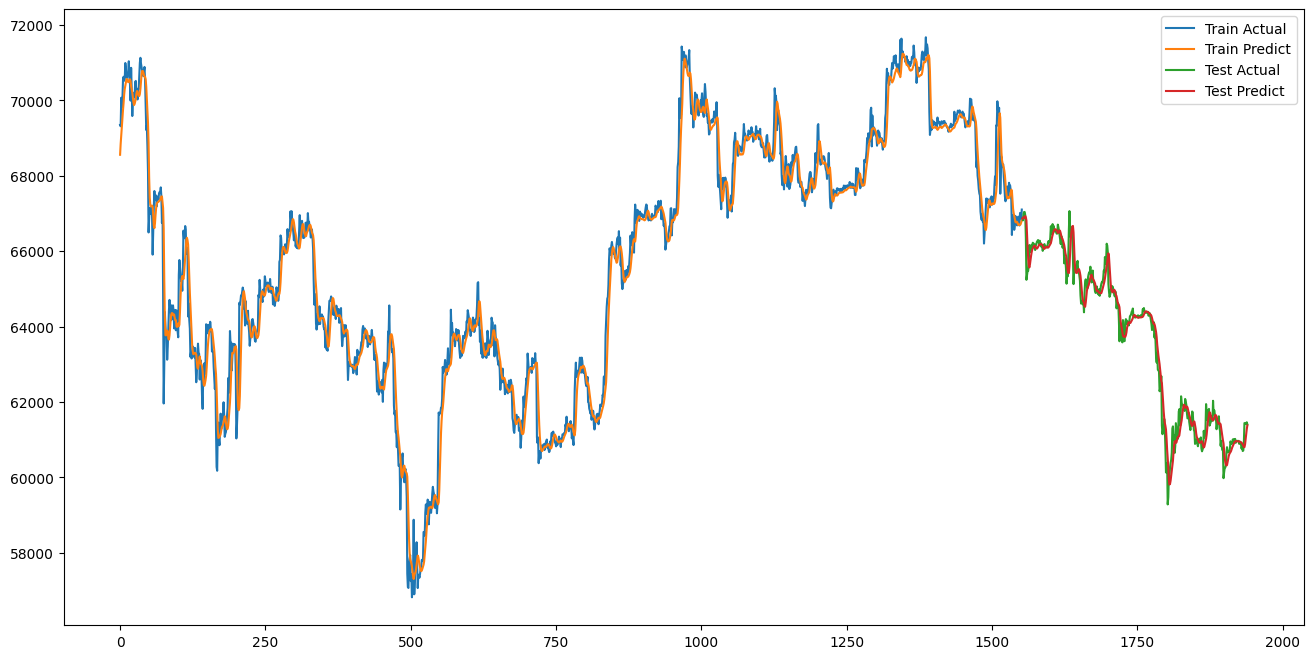

In [13]:
# Evaluate the model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the predictions
train_predict = scaler.inverse_transform(np.concatenate((train_predict, np.zeros((train_predict.shape[0], len(features) - 1))), axis=1))[:, 0]
test_predict = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], len(features) - 1))), axis=1))[:, 0]

# Inverse transform the actual values
y_train_actual = scaler.inverse_transform(np.concatenate((y_train.reshape(-1, 1), np.zeros((y_train.shape[0], len(features) - 1))), axis=1))[:, 0]
y_test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], len(features) - 1))), axis=1))[:, 0]

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
plt.plot(y_train_actual, label='Train Actual')
plt.plot(train_predict, label='Train Predict')
plt.plot(np.arange(len(y_train_actual), len(y_train_actual) + len(y_test_actual)), y_test_actual, label='Test Actual')
plt.plot(np.arange(len(y_train_actual), len(y_train_actual) + len(y_test_actual)), test_predict, label='Test Predict')
plt.legend()
plt.show()


/home/amankumar/anaconda3/envs/cryp/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1552/1552 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - loss: 0.0094
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


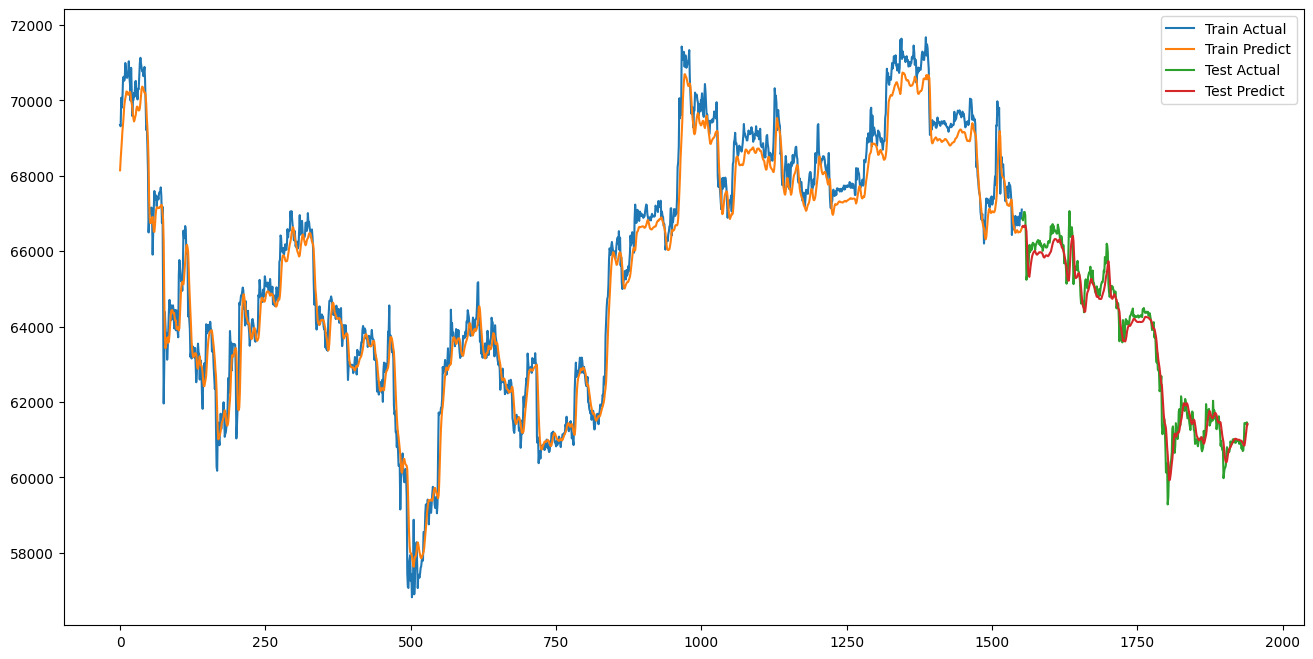

In [32]:
import numpy as np
import pandas as pd
import requests
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Fetch historical data
def fetch_data(symbol, comparison_symbol, limit):
    url = f'https://min-api.cryptocompare.com/data/v2/histohour?fsym={symbol}&tsym={comparison_symbol}&limit={limit}'
    response = requests.get(url)
    data = response.json()
    return pd.DataFrame(data['Data']['Data'])

# Fetch data for the last 2000 hours
df = fetch_data('BTC', 'USD', 2000)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)

# Select features and target
features = ['open', 'high', 'low', 'close', 'volumefrom', 'volumeto']
target = 'close'

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

# Prepare the data for LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step), :])
        y.append(data[i + time_step, 3])  # target is 'close'
    return np.array(X), np.array(y)

time_step = 60  # Use past 60 hours to predict the next hour
X, y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], len(features))

# Split into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, len(features))))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=1)

# Evaluate the model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the predictions
train_predict = scaler.inverse_transform(np.concatenate((train_predict, np.zeros((train_predict.shape[0], len(features) - 1))), axis=1))[:, 0]
test_predict = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], len(features) - 1))), axis=1))[:, 0]

# Inverse transform the actual values
y_train_actual = scaler.inverse_transform(np.concatenate((y_train.reshape(-1, 1), np.zeros((y_train.shape[0], len(features) - 1))), axis=1))[:, 0]
y_test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], len(features) - 1))), axis=1))[:, 0]

# Plot the results
plt.figure(figsize=(16,8))
plt.plot(y_train_actual, label='Train Actual')
plt.plot(train_predict, label='Train Predict')
plt.plot(np.arange(len(y_train_actual), len(y_train_actual) + len(y_test_actual)), y_test_actual, label='Test Actual')
plt.plot(np.arange(len(y_train_actual), len(y_train_actual) + len(y_test_actual)), test_predict, label='Test Predict')
plt.legend()
plt.show()


In [33]:

# Function to predict the closing price for the next N hours
def predict_next_hours(model, last_data, num_hours, time_step, features, start_time):
    predictions = []
    timestamps = []
    data = last_data.copy()
    current_time = start_time

    for _ in range(num_hours):
        scaled_data = scaler.transform(data[-time_step:])
        X_input = scaled_data.reshape(1, time_step, len(features))
        pred = model.predict(X_input)
        pred_inversed = scaler.inverse_transform(np.concatenate((pred, np.zeros((pred.shape[0], len(features) - 1))), axis=1))[:, 0]
        predictions.append(pred_inversed[0])
        timestamps.append(current_time)
        current_time += pd.Timedelta(hours=1)

        # Add the predicted value as the next 'close' and shift the window
        new_row = np.append(data[-1, 1:], pred_inversed[0]).reshape(1, len(features))
        data = np.vstack([data, new_row])
    
    return pd.DataFrame({'time': timestamps, 'predicted_close': predictions})

# Get the last 'time_step' rows from the scaled data for prediction
last_data = df[features].values[-time_step:]
start_time = df.index[-1]

# Predict the closing price for the next 24 hours
predictions_df = predict_next_hours(model, last_data, 24, time_step, features, start_time)
print(predictions_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/home/amankumar/anaconda3/envs/cryp/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/amankumar/anaconda3/envs/cryp/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/amankumar/anaconda3/envs/cryp/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/amankumar/anaconda3/envs/cryp/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/amankumar/anaconda3/envs/cryp/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/home/amankumar/anaconda3/envs/cryp/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/amankumar/anaconda3/envs/cryp/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/amankumar/anaconda3/envs/cryp/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/amankumar/anaconda3/envs/cryp/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/amankumar/anaconda3/envs/cryp/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


/home/amankumar/anaconda3/envs/cryp/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/amankumar/anaconda3/envs/cryp/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/amankumar/anaconda3/envs/cryp/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/amankumar/anaconda3/envs/cryp/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/amankumar/anaconda3/envs/cryp/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
                  time  predicted_close
0  2024-06-30 13:00:00     61478.892163
1  2024-06-30 14:00:00     60883.263250
2  2024-06-30 15:00:00     67147.547701
3  2024-06-30 16:00:00     77152.275758
4  2024-06-30 17:00:00     80649.228563
5  2024-06-30 18:00:00     70319.487246
6  2024-06-30 19:00:00     66096.893640
7  2024-06-30 20:00:00     65595.293437
8  2024-06-30 21:00:00     67232.520112
9  2024-06-30 22:00:00     68661.023959
10 2024-06-30 23:00:00     68934.839200
11 2024-07-01 00:00:00     68518.214190
12 2024-07-01 01:00:00     68109.127982
13 2024-07-01 02:00:00     67914.960700
14 2024-07-01 03:00:00     67898.394808
15 2024-07-01 04:00:00     67941.212053
16 2024-07-01 05:00:00     67959.932949
17 2024-07-01 06:00:00     67936.613662
18 2024-07-01 07:00:00     67890.674258
19 2024-07

/home/amankumar/anaconda3/envs/cryp/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/amankumar/anaconda3/envs/cryp/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/amankumar/anaconda3/envs/cryp/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/amankumar/anaconda3/envs/cryp/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [6]:
import requests
import pandas as pd
import datetime as dt

def fetch_data(symbol, comparison_symbol, limit, to_date=None):
    base_url = 'https://min-api.cryptocompare.com/data/v2/histohour'
    if to_date is not None:
        # Convert the to_date to a Unix timestamp
        toTs = int(dt.datetime.strptime(to_date, '%Y-%m-%d').timestamp())
        url = f'{base_url}?fsym={symbol}&tsym={comparison_symbol}&limit={limit}&toTs={toTs}'
    else:
        url = f'{base_url}?fsym={symbol}&tsym={comparison_symbol}&limit={limit}'
    
    response = requests.get(url)
    data = response.json()
    return pd.DataFrame(data['Data']['Data'])

# Example usage:
# Fetch data for the last 2000 hours up to a specific date
df = fetch_data('BTC', 'USD', 2000, to_date='2024-07-01')
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)

print(df.head())


                         high       low      open  volumefrom      volumeto  \
time                                                                          
2024-04-08 10:00:00  72368.13  71792.02  72188.68     2035.97  1.467076e+08   
2024-04-08 11:00:00  72626.33  72221.64  72316.23     1386.11  1.003108e+08   
2024-04-08 12:00:00  72750.51  72132.72  72374.83     2006.35  1.453238e+08   
2024-04-08 13:00:00  72281.11  71676.20  72175.41     2613.36  1.881341e+08   
2024-04-08 14:00:00  71970.00  71245.26  71937.84     3272.39  2.343731e+08   

                        close conversionType conversionSymbol  
time                                                           
2024-04-08 10:00:00  72316.23         direct                   
2024-04-08 11:00:00  72374.83         direct                   
2024-04-08 12:00:00  72175.41         direct                   
2024-04-08 13:00:00  71937.84         direct                   
2024-04-08 14:00:00  71704.68         direct                  

In [7]:
df

,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
time,,,,,,,,
2024-04-08 10:00:00,72368.13,71792.02,72188.68,2035.97,1.467076e+08,72316.23,direct,
2024-04-08 11:00:00,72626.33,72221.64,72316.23,1386.11,1.003108e+08,72374.83,direct,
2024-04-08 12:00:00,72750.51,72132.72,72374.83,2006.35,1.453238e+08,72175.41,direct,
2024-04-08 13:00:00,72281.11,71676.20,72175.41,2613.36,1.881341e+08,71937.84,direct,
2024-04-08 14:00:00,71970.00,71245.26,71937.84,3272.39,2.343731e+08,71704.68,direct,
...,...,...,...,...,...,...,...,...
2024-06-30 14:00:00,61744.91,61437.84,61613.71,670.88,4.130302e+07,61499.49,direct,
2024-06-30 15:00:00,61679.04,61498.68,61499.49,309.41,1.905608e+07,61625.97,direct,
2024-06-30 16:00:00,61652.70,61492.74,61625.97,274.79,1.691136e+07,61520.89,direct,


In [ ]:
import numpy as np
import pandas as pd
import requests
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import joblib

# Fetch historical data
def fetch_data(symbol, comparison_symbol, limit):
    url = f'https://min-api.cryptocompare.com/data/v2/histohour?fsym={symbol}&tsym={comparison_symbol}&limit={limit}'
    response = requests.get(url)
    data = response.json()
    return pd.DataFrame(data['Data']['Data'])

# Fetch data for the last 2000 hours
df = fetch_data('BTC', 'USD', 2000)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)

# Select features and target
features = ['open', 'high', 'low', 'close', 'volumefrom', 'volumeto']
target = 'close'

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

# Save the scaler
joblib.dump(scaler, 'scaler.save')

# Prepare the data for LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step), :])
        y.append(data[i + time_step, 3])  # target is 'close'
    return np.array(X), np.array(y)

time_step = 60  # Use past 60 hours to predict the next hour
X, y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], len(features))

# Split into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, len(features))))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=1)

# Save the trained model
model.save('lstm_model.h5')

# Function to predict the closing price for the next N hours
def predict_next_hours(model, last_data, num_hours, time_step, features, start_time):
    predictions = []
    timestamps = []
    data = last_data.copy()
    current_time = start_time

    for _ in range(num_hours):
        scaled_data = scaler.transform(data[-time_step:])
        X_input = scaled_data.reshape(1, time_step, len(features))
        pred = model.predict(X_input)
        pred_inversed = scaler.inverse_transform(np.concatenate((pred, np.zeros((pred.shape[0], len(features) - 1))), axis=1))[:, 0]
        predictions.append(pred_inversed[0])
        timestamps.append(current_time)
        current_time += pd.Timedelta(hours=1)

        # Add the predicted value as the next 'close' and shift the window
        new_row = np.append(data[-1, 1:], pred_inversed[0]).reshape(1, len(features))
        data = np.vstack([data, new_row])
    
    return pd.DataFrame({'time': timestamps, 'predicted_close': predictions})

# Later, load the model and scaler for inference

# Load the saved model
saved_model = load_model('lstm_model.h5')

# Load the saved scaler
scaler = joblib.load('scaler.save')

# Example usage
# Get the last 'time_step' rows from the scaled data for prediction
last_data = df[features].values[-time_step:]
start_time = df.index[-1]

# Predict the closing price for the next 24 hours
predictions_df = predict_next_hours(saved_model, last_data, 24, time_step, features, start_time)
print(predictions_df)


# Streamlit

2024-07-08 23:32:55.643 
  command:

    streamlit run /home/amankumar/anaconda3/envs/cryp/lib/python3.12/site-packages/ipykernel_launcher.py [ARGUMENTS]


DeltaGenerator()

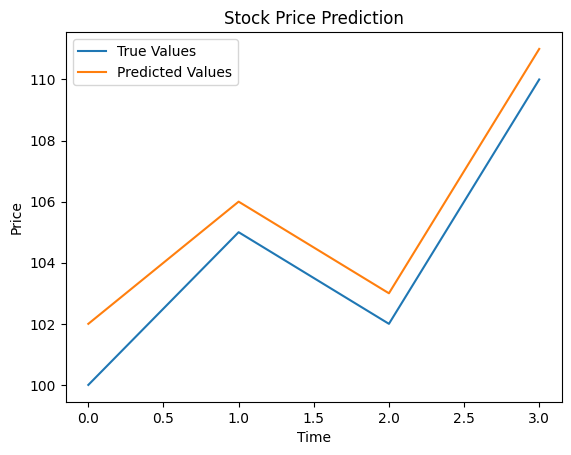

In [2]:
import streamlit as st
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

# Dummy functions for prediction, replace with your actual prediction function
def predict_next_price():
    # Replace with actual prediction logic
    return 150.0

def get_metrics(true_values, predicted_values):
    mape = mean_absolute_percentage_error(true_values, predicted_values)
    mse = mean_squared_error(true_values, predicted_values)
    return mape, mse

# Dummy historical data and prediction, replace with actual data
true_values = np.array([100, 105, 102, 110])
predicted_values = np.array([102, 106, 103, 111])
mape, mse = get_metrics(true_values, predicted_values)

# Streamlit app
st.title("Stock Price Prediction")

# Display prediction
predicted_price = predict_next_price()
st.write(f"**Predicted Price:** {predicted_price:.2f}")

# Display metrics
st.write(f"**MAPE:** {mape:.2%}")
st.write(f"**MSE:** {mse:.2f}")


import pandas as pd
df = pd.read_csv('/home/amankumar/prac/imp/crypto/predictions.csv')


# Plotting
fig, ax = plt.subplots()
ax.plot(true_values, label='True Values')
ax.plot(predicted_values, label='Predicted Values')
ax.plot(df, label='Predicted Values_predicted')

ax.plot()
ax.legend()
ax.set_title("Stock Price Prediction")
ax.set_xlabel("Time")
ax.set_ylabel("Price")
st.pyplot(fig)
